# Importing data

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#Import the excel file, the first sheet is the surface elevation, the second sheet is the formation and well info
filepath = r"C:\Users\thomas_ja\Desktop\CrossSectionTool\Copy of x_sec_data.xlsx"
df_elev = pd.read_excel(filepath, sheet_name='Elev')
df_cross = pd.read_excel(filepath, sheet_name='Xsecs')

#Here we split the well info sheet into formations and styles
df_formations = df_cross.set_index('W_NUM').loc[:, 'FORM_START' : 'STYLE_START'].drop(columns=['FORM_START', 'STYLE_START'])
df_style      = df_cross.set_index('W_NUM').loc[:, 'STYLE_START':].drop(columns=['STYLE_START'])


df_elev.head(10)

,OBJECTID *,Shape *,ORIG_LEN,ORIG_SEQ,XSec,LiDAR_Elev,Distance_Ft,ACTUAL_DISTANCE
0,1,Point,0.000000,1,B-B',28.67214,500,0
1,2,Point,0.001565,2,B-B',28.32927,1000,500
2,3,Point,0.003129,3,B-B',25.84028,1500,1000
3,4,Point,0.004694,4,B-B',26.83729,2000,1500
4,5,Point,0.006259,5,B-B',26.71501,2500,2000
5,6,Point,0.007823,6,B-B',26.43321,3000,2500
6,7,Point,0.009388,7,B-B',27.53563,3500,3000
7,8,Point,0.010953,8,B-B',27.27418,4000,3500
8,9,Point,0.012517,9,B-B',26.93416,4500,4000
9,10,Point,0.014082,10,B-B',23.85880,5000,4500


# Functions for the creation of pinching out points

In [194]:
def check_left_right(style_row, index):
    """
    style_row - array of characters: p, n, x, f
    index     - integer of where a pinch or fade is said to be

    Uses the index to search the style_row for the direction of pinching and fading.

    """
    # If it is the last item in the array then the direction is left
    if index == (len(style_row)-1) and style_row[index - 1] == 'n' :
        return 'left'
    # If it is the first item in the array then the direction is right
    elif index == 0 and style_row[index + 1] == 'n':
        return 'right'
    # If both directions are void, then pinch in both directions
    elif style_row[index - 1] == 'n' and style_row[index + 1] == 'n':
        return 'both'
    # If the item before is void, pinch to the left
    elif style_row[index - 1] == 'n':
        return 'left'
    # If the item after is void pinch to the right
    elif style_row[index + 1] == 'n':
        return 'right'


#######################################################################################################################################################


def find_bottom(style_array, row, index, direction):
    """
    style_array - array of characters: n, p, f, x.
    row         - integer, the row of the style array currently being worked
    index       - integer, the index at which the pinch of fade currently being calculated is at
    direction   - string: left, righ, both. The direction in which the formation pinches or fades

    Finds the non np.nan values for the slope calculation later.
    """
    #Creates an empty list to add row number to later
    slope_rows = []

    if direction == 'left':
        #If direction is left, it will grab the appropriate two values from the next row
        slope_points = style_array[row+1][[index-1, index]]
        n=0 # Increment for rows of the style array, used in the while loop
        #Then checks if they both are not np.nan
        if np.all(slope_points == ['x', 'x']):
            slope_rows.append(row+1) # Adds to the list if not np.nan
        else:
            while np.any(slope_points != ['x', 'x']): #Searches downwards until it finds 2 values that aren't np.nan
                n += 1
                slope_points=style_array[row+1+n][[index, index+1]]
            slope_rows.append(row+1+n)
            

    elif direction == 'right':
        #If direction is right, it will grab the appropriate two values from the next row
        slope_points = style_array[row+1][[index, index+1]]
        n=0 # Increment for rows of the style array, used in the while loop
        if np.all(slope_points == ['x', 'x']):
            slope_rows.append(row+1)# Adds to the list if not np.nan
        else:
            while np.any(slope_points != ['x', 'x']): #Searches downwards until it finds 2 values that aren't np.nan
                n += 1
                slope_points=style_array[row+1+n][[index, index+1]]
            slope_rows.append(row+1+n)
            

    elif direction == 'both': 
        #If direction is both we must grab four values to check the value to the left and right of the pinch point
        slope_right=style_array[row+1][[index, index+1]]
        slope_left=style_array[row+1][[index-1, index]]
        n=0 # Increment for rows of the style array, used in the while loop
        if np.all(slope_left == ['x','x']): #This checks the left side for np.nan values
            slope_rows.append(row+1)# Adds to the list if not np.nan
        else:
            while np.any(slope_left != ['x', 'x']):
                n += 1
                slope_left=style_array[row+1+n][[index, index+1]]
            slope_rows.append(row+1+n)
            
        n=0 # Increment for rows of the style array, used in the while loop
        if np.all(slope_right == ['x', 'x']): #This checks the right side for np.nan values
            slope_rows.append(row+1)# Adds to the list if not np.nan
        else:
            while np.any(slope_right != ['x', 'x']):
                n += 1
                slope_right=style_array[row+1+n][[index, index+1]]
            slope_rows.append(row+1+n)

    return slope_rows


#######################################################################################################################################################


def slope_calculator(formations_array, style_array, distance, row, index, direction):
    """
    formations_array - array of floats, top depth of formations
    style_array      - array of characters: n, p, f, x
    distance         - array of integers or floats, indicating the distance from the start of the cross section that each well is at
    row              - integer, the row of the style array currently being worked
    index            - integer, the index at which the pinch of fade currently being calculated is at
    direction        - string: left, righ, both. The direction in which the formation pinches or fades 
    """
    
    if direction == 'right':
        slope_rows = find_bottom(style_array, row, index, direction)
        depth1 = formations_array[slope_rows, index][0]
        depth2 = formations_array[slope_rows, index+1][0]

        distance1 = distance[index]
        distance2 = distance[index+1]
        

        slope = (depth1 - depth2) / (distance1 - distance2)
        midpoint = (distance1 + distance2) / 2
        yintercept = depth1 - (slope * distance1)
        point = (slope * midpoint) + yintercept


        new_point = np.array([[point], [point], [midpoint]])

        return new_point

    elif direction == 'left':
        slope_rows = find_bottom(style_array, row, index, direction)
        depth1 = formations_array[slope_rows, index][0]
        depth2 = formations_array[slope_rows, index-1][0]

        distance1 = distance[index]
        distance2 = distance[index-1]
        

        slope = (depth1 - depth2) / (distance1 - distance2)
        midpoint = (distance1 + distance2) / 2
        yintercept = depth1 - (slope * distance1)
        point = (slope * midpoint) + yintercept

        new_point = np.array([[point], [point], [midpoint]])

        return new_point

    
    elif direction == 'both':
        left_right_points = []
        slope_rows = find_bottom(style_array, row, index, direction)
        #Calculate the left point
        
        depth1 = formations_array[slope_rows[0], index]
        depth2 = formations_array[slope_rows[0], index-1]

        distance1 = distance[index]
        distance2 = distance[index-1]
        
        slope = (depth1 - depth2) / (distance1 - distance2)
        midpoint = (distance1 + distance2) / 2
        yintercept = depth1 - (slope * distance1)
        point = (slope * midpoint) + yintercept

        new_point = np.array([[point], [point], [midpoint]])
        left_right_points.append(new_point)

        #Calculate the right point
        depth1 = formations_array[slope_rows[1], index]
        depth2 = formations_array[slope_rows[1], index+1]

        distance1 = distance[index]
        distance2 = distance[index+1]
        
        slope = (depth1 - depth2) / (distance1 - distance2)
        midpoint = (distance1 + distance2) / 2
        yintercept = depth1 - (slope * distance1)
        point = (slope * midpoint) + yintercept

        new_point = np.array([[point], [point], [midpoint]])
        left_right_points.append(new_point)

        return left_right_points
        


In [195]:
#This creates an array that can be plotted later. Surface elevation
elev = df_elev['LiDAR_Elev'].tolist()
distance = df_elev["ACTUAL_DISTANCE"].tolist()
elev_array = np.array([elev, distance])

#This extracts the distances for each well and the elevation of each well
locations = df_cross['DIST_FT'].tolist()
well_elev = np.array(df_cross['DEM_ELEV'].tolist())
locations

[0, 4500, 8000, 11633, 21870]

In [196]:
df_formations.head()

,TQSU,INTER,HTRN,OCAL,AVPK,BTM
W_NUM,,,,,,
16011,24,82.0,92,92,95.0,99
9999,30,NaN,90,90,100.0,110
1111,50,79.0,89,89,NaN,115
3475,63,79.0,89,89,NaN,126
14710,0,NaN,85,105,230.0,300


In [197]:
#This creates a list of all the formation names from the formation dataframe column headers
formations_list = df_formations.columns.tolist()

#This creates an array of the formation tops
all_formations = []
for formation in formations_list:
    temp_list = df_formations[formation].tolist()
    all_formations.append(temp_list)
formations_array = np.array(all_formations)

#Creates a mask that is used for the true formation depth calculation later
not_elev = formations_array != 0
#Creates an array of repeated well elevations that is used to calculate true formation depth
elev_stack = np.repeat([well_elev], formations_array.shape[0], axis=0)

#Calculates true formation depth by the difference of elevation and formation top only for values that arent equal to 0
formations_array[not_elev] = elev_stack[not_elev] - formations_array[not_elev]
#Calculates true formation depth by the sum of elevation and formation top for the values that are 0
formations_array[~not_elev] = elev_stack[~not_elev] + formations_array[~not_elev]

formations_array

array([[   4.6,   -6.2,  -45.2,  -57.9,   10.9],
       [ -53.4,    nan,  -74.2,  -73.9,    nan],
       [ -63.4,  -66.2,  -84.2,  -83.9,  -74.1],
       [ -63.4,  -66.2,  -84.2,  -83.9,  -94.1],
       [ -66.4,  -76.2,    nan,    nan, -219.1],
       [ -70.4,  -86.2, -110.2, -120.9, -289.1]])

In [198]:
#Creates a list of style column headers
style_columns = df_style.columns.tolist()

#Creates an array of the style indicators that can be used for the polygon calculation decisions
all_styles = []
for style in style_columns:
    temp_list = df_style[style].tolist()
    all_styles.append(temp_list)
style_array = np.array(all_styles).astype('U')
style_array

array([['x', 'x', 'x', 'x', 'x'],
       ['f', 'n', 'p', 'f', 'n'],
       ['x', 'x', 'x', 'x', 'x'],
       ['x', 'x', 'x', 'x', 'x'],
       ['x', 'p', 'n', 'n', 'p'],
       ['x', 'x', 'x', 'x', 'x']], dtype='<U1')

In [199]:
#Creates a copy of the formation array so that the original is preserved
big_array = np.copy(formations_array)

#Creates initial polygons for each formation, making sure that if the top of the formation is np.nan the bottom is too. 
#Also makes sure that if the formation below has np.nan as a value, it searches the next one down to make sure it has a number in the formation bottom
initial_polygon_list = []
for row in range(big_array.shape[0] - 1):
    first_row = np.copy(big_array[row])
    nan_template = np.isnan(first_row)

    second_row = np.copy(big_array[row + 1])
    second_row[nan_template] = np.nan
    nan_second = np.isnan(second_row)

    run = 2
    while not np.array_equal(nan_template, nan_second):
        values_needed = nan_template != nan_second
        second_row[values_needed] = big_array[row + run][values_needed]
        run += 1
        nan_second = np.isnan(second_row)
    #Append each initial polygon to a list where they can be accessed during the final polygon calculation
    initial_polygon_list.append(np.array([first_row, second_row]))

initial_polygon_list

[array([[  4.6,  -6.2, -45.2, -57.9,  10.9],
        [-53.4, -66.2, -74.2, -73.9, -74.1]]),
 array([[-53.4,   nan, -74.2, -73.9,   nan],
        [-63.4,   nan, -84.2, -83.9,   nan]]),
 array([[-63.4, -66.2, -84.2, -83.9, -74.1],
        [-63.4, -66.2, -84.2, -83.9, -94.1]]),
 array([[ -63.4,  -66.2,  -84.2,  -83.9,  -94.1],
        [ -66.4,  -76.2, -110.2, -120.9, -219.1]]),
 array([[ -66.4,  -76.2,    nan,    nan, -219.1],
        [ -70.4,  -86.2,    nan,    nan, -289.1]])]

In [201]:
########################################################################################################################################################
# The final polygon creation process
# Each polygon will be created in the same form 3-rows, 2Dimensions
# Row-1 is the formation top
# Row-2 is the formation bottom
# Row-3 is the corresponding x value for the depths in rows 1&2
# Polygons will not necessarily be of the same length, this is why they are added to a list and calulated seperately.
# That is also why the polygons all will contain their own x values within them.
########################################################################################################################################################
formation_polygons = []

for row in range(len(initial_polygon_list)):
#Calculates the polygons for formations that fade
    total_stack = initial_polygon_list[row].copy()
    total_stack = np.vstack((total_stack, locations))
    sorted_fade_index = 'NO'
    if np.any(style_array[row] == 'f'):

        fade_index = np.where(style_array[row] == 'f')[0]
        sorted_fade_index = np.sort(fade_index)
        insert_index_correction = 0

        for fade in fade_index:
            direction = check_left_right(style_array[row], fade)
            
    #Calculates the fade polygon if the formation fades left
            if direction == 'left':
                insert_location = fade + insert_index_correction
                #Check for interlocking vs pool case
                if row != 0:
                    #In interlocking cases, the above formation will be blocky and the below formation will have the teeth
                    if np.all(style_array[row-1, fade-1:fade+1] == ['f', 'n']): #Creates the fade polygon between two interlocking formations
                       
                        midpoint = (locations[fade] + locations[fade-1]) / 2
                        teeth_point = midpoint * 1.03

                        top_slope = (initial_polygon_list[row][0, fade] - initial_polygon_list[row-1][0, fade-1]) / (locations[fade] - locations[fade-1])
                        yintercept = initial_polygon_list[row][0, fade] - (top_slope * distance[fade])
                        top_midpoint_elev = (top_slope * midpoint) + yintercept
                        print("Top elev", top_midpoint_elev)

                        bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row-1][1, fade-1]) / (locations[fade] - locations[fade-1])
                        yintercept = initial_polygon_list[row][1, fade] - (bottom_slope * distance[fade])
                        bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                        bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept

                        peaks_and_troughs = np.linspace(bottom_midpoint_elev, top_midpoint_elev, num=7)
                        peak_locations = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                        bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                        interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                        total_stack = np.insert(total_stack, [insert_location], interlock_figure_array, axis=1)
                        insert_index_correction += 7
                        

                    elif np.all(style_array[row+1, fade-1:fade+1] == ['f', 'n']):#Creates a blocky polygon to draw over if the formation below interlocks
                        new_stack = np.array([[initial_polygon_list[row+1][0,fade+1]], [initial_polygon_list[row+1][1,fade+1]], [locations[fade+1]]])
                        total_stack = np.insert(total_stack, [insert_location+1], new_stack, axis=1)


                    
                    else:
                        #Calculate the universal values for this interlocking figure
                        thickness = initial_polygon_list[row][0, fade] - initial_polygon_list[row][1, fade]
                        midpoint = (locations[fade] + locations[fade-1]) / 2
                        teeth_point = midpoint * 1.03
                        #Calculate the bottom slope values
                        bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row+1][0, fade-1]) / (locations[fade] - locations[fade-1])
                        yintercept = initial_polygon_list[row][1, fade] - (bottom_slope * distance[fade])
                        bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                        bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept
                        #Calculate the top elev with thickness and bottom midpoint elevation
                        top_midpoint_elev = bottom_midpoint_elev + thickness
    
                        if top_midpoint_elev > initial_polygon_list[row][0, fade]:
                            print("Greater than")
                            top_midpoint_elev = initial_polygon_list[row][0, fade]
                        #Calculate the points between top and bottom
                        peaks_and_troughs = np.linspace(bottom_midpoint_elev, top_midpoint_elev, num = 7)
                        peak_locations  = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                        bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                        interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                        total_stack = np.insert(total_stack, [insert_location], interlock_figure_array, axis=1)
                        insert_index_correction += 7


        #Calculates the fade polygon if the formation fades right
            elif direction == 'right':
                insert_location = fade + insert_index_correction
                #Check for interlocking vs pool case
                if row != 0:
                    #In interlocking cases, the above formation will be blocky and the below formation will have the teeth
                    if np.all(style_array[row-1, fade:fade+2] == ['n', 'f']):
                        midpoint = (locations[fade] + locations[fade+1]) / 2
                        teeth_point = midpoint * 0.97

                        top_slope = (initial_polygon_list[row][0, fade] - initial_polygon_list[row-1][0, fade+1]) / (locations[fade] - locations[fade+1])
                        yintercept = initial_polygon_list[row][0, fade] - (top_slope * distance[fade])
                        top_midpoint_elev = (top_slope * midpoint) + yintercept
                       

                        bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row-1][1, fade+1]) / (locations[fade] - locations[fade+1])
                        yintercept = initial_polygon_list[row][1, fade] - (bottom_slope * distance[fade])
                        bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                        bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept

                        peaks_and_troughs = np.linspace(top_midpoint_elev, bottom_midpoint_elev, num=7)
                        peak_locations = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                        bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                        interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                        
    
                        total_stack = np.insert(total_stack, [insert_location], interlock_figure_array, axis=1)
                        insert_index_correction += 7
                        
                        
                    elif np.all(style_array[row+1, fade:fade+2] == ['n', 'f']): #Creates a blocky polygon to draw over if the formation below interlocks
                        new_stack = np.array([[initial_polygon_list[row+1][0,fade+1]], [initial_polygon_list[row+1][1,fade+1]], [locations[fade+1]]])
                        total_stack = np.insert(total_stack, [insert_location+1], new_stack, axis=1)
            

                    
                    else:
                        thickness = initial_polygon_list[row][0, fade] - initial_polygon_list[row][1, fade]
                        midpoint = (locations[fade] + locations[fade+1]) / 2
                        teeth_point = midpoint * 0.97

                        bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row+1][0, fade+1]) / (locations[fade] - locations[fade+1])
                        yintercept = initial_polygon_list[row][1, fade] - (bottom_slope * locations[fade])
                        bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                        bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept

                        top_midpoint_elev = bottom_midpoint_elev + thickness

                        peaks_and_troughs = np.linspace(top_midpoint_elev, bottom_midpoint_elev, num=7)
                        peak_locations = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                        bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                        interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                        

                        total_stack = np.insert(total_stack, [insert_location+1], interlock_figure_array, axis=1)
                        insert_index_correction += 7

                        



            elif direction == 'both':
                insert_location = fade + insert_index_correction

                #In interlocking cases, the above formation will be blocky and the below formation will have the teeth
                if np.all(style_array[row-1, fade-1:fade+1] == ['f', 'n']): #Interlocks above
                       
                    midpoint = (locations[fade] + locations[fade-1]) / 2
                    teeth_point = midpoint * 1.03

                    top_slope = (initial_polygon_list[row][0, fade] - initial_polygon_list[row-1][0, fade-1]) / (locations[fade] - locations[fade-1])
                    yintercept = initial_polygon_list[row][0, fade] - (top_slope * distance[fade])
                    top_midpoint_elev = (top_slope * midpoint) + yintercept
                    

                    bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row-1][1, fade-1]) / (locations[fade] - locations[fade-1])
                    yintercept = initial_polygon_list[row][0, fade] - (bottom_slope * distance[fade])
                    bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                    bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept

                    peaks_and_troughs = np.linspace(bottom_midpoint_elev, top_midpoint_elev, num=7)
                    peak_locations = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                    bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                    interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                    total_stack = np.insert(total_stack, [insert_location], interlock_figure_array, axis=1)
                    insert_index_correction += 7
                        
                    #Creates a blocky polygon to draw over if the formation below interlocks
                elif np.all(style_array[row+1, fade-1:fade+1] == ['f', 'n']): #Interlocks below
                    new_stack = np.array([[initial_polygon_list[row+1][0,fade+1]], [initial_polygon_list[row+1][1,fade+1]], [locations[fade+1]]])
                    total_stack = np.insert(total_stack, [insert_location+1], new_stack, axis=1)
                    insert_index_correction += 1


                    
                else: #No interlocking
                    #Calculate the universal values for this interlocking figure
                    thickness = initial_polygon_list[row][0, fade] - initial_polygon_list[row][1, fade]
                    midpoint = (locations[fade] + locations[fade-1]) / 2
                    teeth_point = midpoint * 1.03
                    #Calculate the bottom slope values
                    bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row+1][0, fade-1]) / (locations[fade] - locations[fade-1])
                    yintercept = initial_polygon_list[row][1, fade] - (bottom_slope * distance[fade])
                    bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                    bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept
                    #Calculate the top elev with thickness and bottom midpoint elevation
                    top_midpoint_elev = bottom_midpoint_elev + thickness
    
                    if top_midpoint_elev > initial_polygon_list[row][0, fade]:
                        top_midpoint_elev = initial_polygon_list[row][0, fade]
                    #Calculate the points between top and bottom
                    peaks_and_troughs = np.linspace(bottom_midpoint_elev, top_midpoint_elev, num = 7)
                    peak_locations  = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                    bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                    interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                    total_stack = np.insert(total_stack, [insert_location], interlock_figure_array, axis=1)
                    insert_index_correction += 7



                #In interlocking cases, the above formation will be blocky and the below formation will have the teeth
                if np.all(style_array[row-1, fade:fade+2] == ['n', 'f']): #Interlocks above
                    midpoint = (locations[fade] + locations[fade+1]) / 2
                    teeth_point = midpoint * 0.97

                    top_slope = (initial_polygon_list[row][0, fade] - initial_polygon_list[row-1][0, fade+1]) / (locations[fade] - locations[fade+1])
                    yintercept = initial_polygon_list[row][0, fade] - (top_slope * distance[fade])
                    top_midpoint_elev = (top_slope * midpoint) + yintercept
                       

                    bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row-1][1, fade+1]) / (locations[fade] - locations[fade+1])
                    yintercept = initial_polygon_list[row][0, fade] - (bottom_slope * distance[fade])
                    bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                    bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept

                    peaks_and_troughs = np.linspace(top_midpoint_elev, bottom_midpoint_elev, num=7)
                    peak_locations = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                    bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                    interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                    total_stack = np.insert(total_stack, [insert_location], interlock_figure_array, axis=1)
                    insert_index_correction += 7
                        
                    #Creates a blocky polygon to draw over if the formation below interlocks
                elif np.all(style_array[row+1, fade:fade+2] == ['n', 'f']): #Interlocks below
                    new_stack = np.array([[initial_polygon_list[row+1][0,fade+1]], [initial_polygon_list[row+1][1,fade+1]], [locations[fade+1]]])
                    total_stack = np.insert(total_stack, [insert_location+1], new_stack, axis=1)
                    insert_index_correction += 1

                    
                else: #No interlocking
                    thickness = initial_polygon_list[row][0, fade] - initial_polygon_list[row][1, fade]
                    midpoint = (locations[fade] + locations[fade+1]) / 2
                    teeth_point = midpoint * 0.97

                    bottom_slope = (initial_polygon_list[row][1, fade] - initial_polygon_list[row+1][0, fade+1]) / (locations[fade] - locations[fade+1])
                    yintercept = initial_polygon_list[row][1, fade] - (bottom_slope * locations[fade])
                    bottom_midpoint_elev = (bottom_slope * midpoint) + yintercept
                    bottom_teeth_elev = (bottom_slope * teeth_point) + yintercept

                    top_midpoint_elev = bottom_midpoint_elev + thickness

                    peaks_and_troughs = np.linspace(top_midpoint_elev, bottom_midpoint_elev, num=7)
                    peak_locations = np.hstack((np.tile([midpoint, teeth_point], 3), midpoint))
                    bottom_array = np.hstack((np.tile([bottom_midpoint_elev, bottom_teeth_elev], 3), bottom_midpoint_elev))

                    interlock_figure_array = np.vstack((peaks_and_troughs, bottom_array, peak_locations))
                    

                    total_stack = np.insert(total_stack, [insert_location+1], interlock_figure_array, axis=1)
                    insert_index_correction += 7

                




                    
########################################################################################################################################################
########################################################################################################################################################
########################################################################################################################################################
#Calculates the polygons for formations that pinch
    if np.any(style_array[row] == 'p'):
        pinch_index = np.where(style_array[row] == 'p')[0]
        insert_index_correction = 0 #Keeps track of how many points have been added to the array to make sure next points are placed correctly
        #Creates the initial stack with distances that can be modified later by adding pinch points
        
        
        
        for pinch in pinch_index:

            if type(sorted_fade_index) != str:
                index_compared_to_fade  = np.searchsorted(sorted_fade_index, pinch)
                pinch_insert_correction = 7 * index_compared_to_fade

            else:
                pinch_insert_correction = insert_index_correction


            
            #Figure out direction of pinch
            direction = check_left_right(style_array[row], pinch)
            print(direction)
            #Calculate midpoint of next formation top
            new_point = slope_calculator(formations_array, style_array, locations, row, pinch, direction)
            
            #Inserts the new data point into the polygon at the right location
            if direction == 'left':
                insert_location = pinch + pinch_insert_correction 
                total_stack = np.insert(total_stack, insert_location, new_point.flatten(), axis=1)
                insert_index_correction +=1
                
            #Adds the point to the right by adding one to the insert location index
            elif direction == 'right':
                insert_location = pinch + pinch_insert_correction + 1
                total_stack = np.insert(total_stack, insert_location, new_point.flatten(), axis=1)
                insert_index_correction +=1

            #Combines the two methods from before to add in two points, one left and one right
            elif direction == 'both':
                insert_location= pinch + pinch_insert_correction
                left_stack = np.insert(total_stack, insert_location, new_point[0].flatten(), axis=1)
                insert_index_correction +=1

                insert_location = pinch + pinch_insert_correction + 1
                total_stack = np.insert(left_stack, insert_location, new_point[1].flatten(), axis=1)
                insert_index_correction +=1
                
            
    
########################################################################################################################################################
########################################################################################################################################################
########################################################################################################################################################
#Calculates the polygons for formations that dont fade or pinch
    else:
        #Checks if the next formation down pinches or fades
        if np.any(style_array[row+1] == 'f') or np.any(style_array[row+1] == 'p'):
            #If it does, the index of where it pinches or fades will be used to replace the bottom value of the top formation with the bottom value
            #of the lower formation, this is for ease of plotting later on.
            total_stack = initial_polygon_list[row].copy()
            bottom_replacements = (style_array[row+1] == 'f') | (style_array[row+1] == 'p')
            total_stack[1][bottom_replacements] =initial_polygon_list[row+1][1][bottom_replacements]
            #Lastly if creates the final polygon in the form of a 3-row 2D array and adds it to a list
            total_stack = np.vstack((total_stack, locations))
            

    formation_polygons.append(total_stack)



formation_polygons

left
right
left


[array([[ 4.6000e+00, -6.2000e+00, -4.5200e+01, -5.7900e+01,  1.0900e+01],
        [-6.3400e+01, -6.6200e+01, -8.4200e+01, -8.3900e+01, -7.4100e+01],
        [ 0.0000e+00,  4.5000e+03,  8.0000e+03,  1.1633e+04,  2.1870e+04]]),
 array([[  -53.4       ,   -54.8       ,   -56.46666667,   -58.13333333,
           -59.8       ,   -61.46666667,   -63.13333333,   -64.8       ,
                    nan,   -75.2       ,   -74.2       ,   -73.9       ,
           -69.        ,   -70.66666667,   -72.33333333,   -74.        ,
           -75.66666667,   -77.33333333,   -79.        ,            nan],
        [  -63.4       ,   -64.8       ,   -64.758     ,   -64.8       ,
           -64.758     ,   -64.8       ,   -64.758     ,   -64.8       ,
                    nan,   -75.2       ,   -84.2       ,   -83.9       ,
           -79.        ,   -79.48109221,   -79.        ,   -79.48109221,
           -79.        ,   -79.48109221,   -79.        ,            nan],
        [    0.        ,  2250.        , 

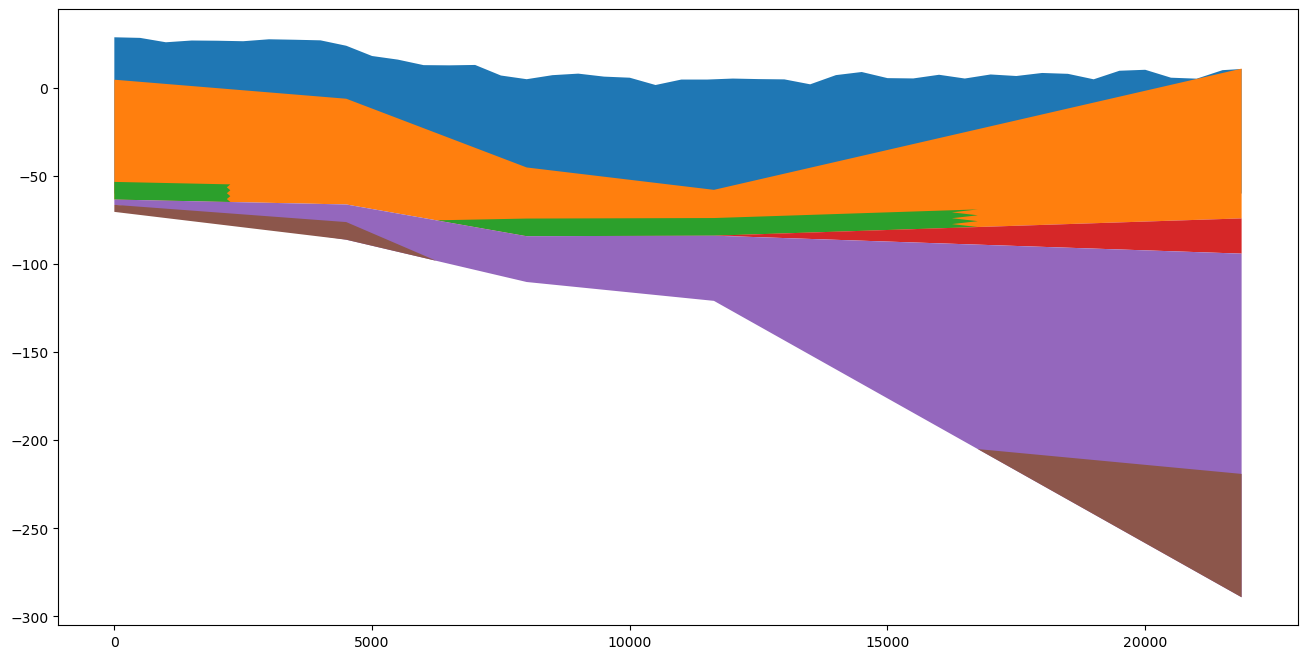

In [202]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.fill_between(distance, -60, elev)

for formation in formation_polygons:
    ax.fill_between(formation[-1], formation[0], formation[1])


# ax.fill_between(locations, initial_polygon_list[0][0], initial_polygon_list[0][1])
# ax.fill_between(locations, initial_polygon_list[2][0], initial_polygon_list[2][1])
plt.show()